Load the Dataset

In [3]:
import pandas as pd

expenses = pd.read_csv(r"C:\Users\user\OneDrive\Documents\finance_ai\data\Expenses_clean.csv")
income = pd.read_csv(r"C:\Users\user\OneDrive\Documents\finance_ai\data\Income_clean.csv")

print("Expenses Data:")
display(expenses.head())

print("Income Data:")
display(income.head())

print("Shape of Expenses:", expenses.shape)
print("Shape of Income:", income.shape)


Expenses Data:


,date_time,category,account,amount,currency,tags
0,2025-11-20 00:00:00,Cafe,acct_1,11.0,BYN,tag_1
1,2025-11-20 00:00:00,Public transport,acct_2,1.0,BYN,tag_1
2,2025-11-20 00:00:00,Cafe,acct_3,9.0,BYN,tag_1
3,2025-11-19 00:00:00,Public transport,acct_2,1.0,BYN,tag_1
4,2025-11-18 00:00:00,Gifts,acct_1,64.0,BYN,tag_1


Income Data:


,date_time,category,account,amount,currency,tags
0,2025-11-18 00:00:00,Job,acct_1,9.0,BYN,tag_1
1,2025-11-15 00:00:00,Job,acct_1,13.0,BYN,tag_2
2,2025-11-15 00:00:00,Job,acct_1,28.0,BYN,tag_1
3,2025-11-15 00:00:00,Job,acct_1,11.0,BYN,tag_3
4,2025-11-15 00:00:00,Debt return / Borrowed money,acct_2,64.0,BYN,tag_4


Shape of Expenses: (914, 6)
Shape of Income: (338, 6)


Merge and Standardize Financial Data

In [4]:
# Mark datasets as Expense / Income
expenses['type'] = 'Expense'
income['type'] = 'Income'

# Combine both datasets
df = pd.concat([expenses, income], ignore_index=True)

# Convert date column to proper datetime
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

# Sort by date
df = df.sort_values('date_time')
df.reset_index(drop=True, inplace=True)

# Save the merged dataset
df.to_csv(r"C:\Users\user\OneDrive\Documents\finance_ai\data\Finance_Merged.csv", index=False)

df.head(), df['type'].value_counts()


(   date_time     category account  amount currency      tags    type
 0 2025-01-03          Job  acct_1    39.0      BYN     tag_4  Income
 1 2025-01-04         Gift  acct_1    33.0      BYN     tag_4  Income
 2 2025-01-04         Gift  acct_1    47.0      BYN     tag_4  Income
 3 2025-01-05  Second work  acct_1   141.0      BYN  2th_work  Income
 4 2025-01-07     Cashback  acct_1     4.0      BYN     tag_4  Income,
 type
 Expense    914
 Income     338
 Name: count, dtype: int64)

Exploratory Data Analysis (EDA)
# Expense vs Income Count


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  1252 non-null   datetime64[ns]
 1   category   1252 non-null   object        
 2   account    1252 non-null   object        
 3   amount     1252 non-null   float64       
 4   currency   1252 non-null   object        
 5   tags       1252 non-null   object        
 6   type       1252 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 68.6+ KB
None
                           date_time       amount
count                           1252  1252.000000
mean   2025-06-21 08:16:52.140574976    31.797125
min              2025-01-03 00:00:00     0.000000
25%              2025-04-01 00:00:00     1.000000
50%              2025-06-25 00:00:00     6.000000
75%              2025-09-12 06:00:00    26.000000
max              2025-11-20 00:00:00  1408.0

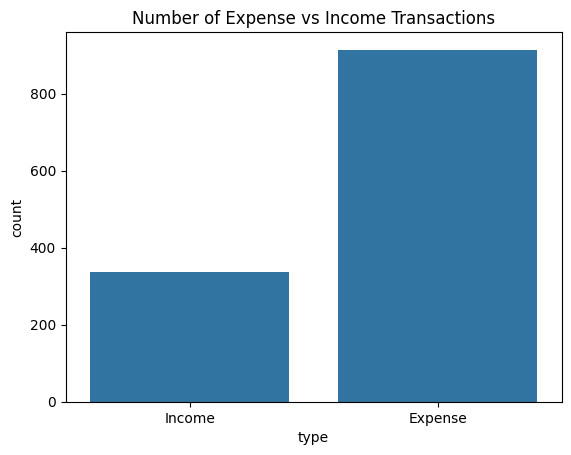

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic info
print(df.info())
print(df.describe())

# Plot Expense vs Income count
sns.countplot(data=df, x='type')
plt.title("Number of Expense vs Income Transactions")
plt.show()


# Monthly Income vs Expense Trend


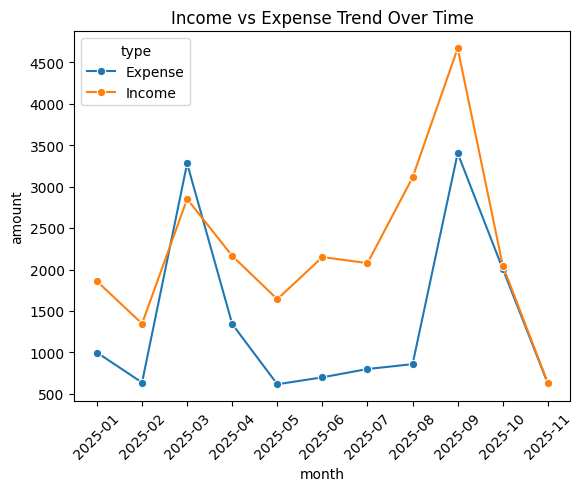

In [6]:
# Extract month-year for grouping
df['month'] = df['date_time'].dt.to_period('M').astype(str)

monthly = df.groupby(['month', 'type'])['amount'].sum().reset_index()

sns.lineplot(data=monthly, x='month', y='amount', hue='type', marker='o')
plt.title("Income vs Expense Trend Over Time")
plt.xticks(rotation=45)
plt.show()



# Category-wise Expense Breakdown


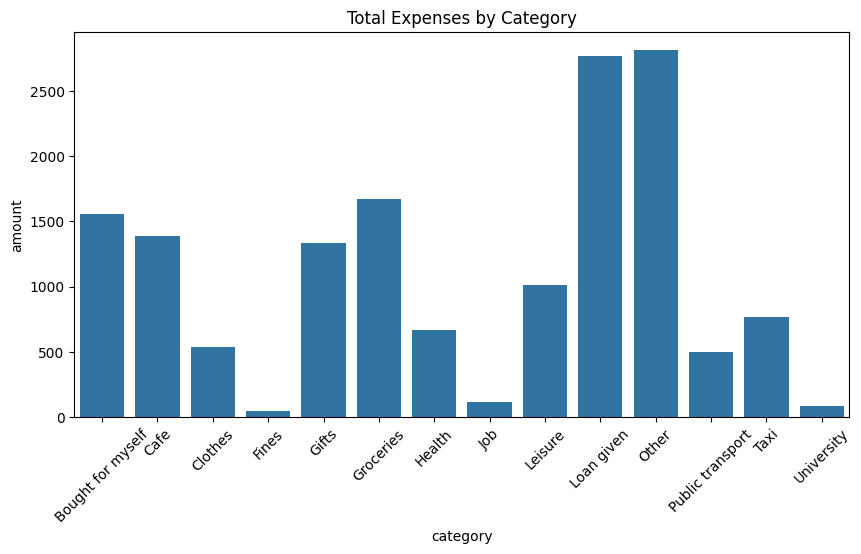

In [7]:
expenses_only = df[df['type'] == 'Expense']

plt.figure(figsize=(10,5))
sns.barplot(data=expenses_only.groupby('category')['amount'].sum().reset_index(),
            x='category', y='amount')
plt.title("Total Expenses by Category")
plt.xticks(rotation=45)
plt.show()


Prepare Data for Machine Learning

In [8]:
df_exp = df[df['type'] == 'Expense'].copy()
df_exp.shape


(914, 8)

In [9]:
print(df_exp.columns)
df_exp.head()


Index(['date_time', 'category', 'account', 'amount', 'currency', 'tags',
       'type', 'month'],
      dtype='object')


,date_time,category,account,amount,currency,tags,type,month
5,2025-01-07,Groceries,acct_1,6.0,BYN,tag_1,Expense,2025-01
6,2025-01-08,Taxi,acct_1,16.0,BYN,tag_1,Expense,2025-01
8,2025-01-09,Taxi,acct_1,16.0,BYN,tag_1,Expense,2025-01
11,2025-01-10,Public transport,acct_2,1.0,BYN,tag_2,Expense,2025-01
13,2025-01-10,Public transport,acct_2,1.0,BYN,tag_2,Expense,2025-01


In [10]:
# Filter only expenses for classification
df_exp = df[df['type'] == 'Expense'].copy()

# Create a text feature by combining useful info
df_exp['text'] = df_exp['account'].astype(str) + " " + df_exp['tags'].astype(str)

# Check the result
df_exp[['text', 'category']].head()


,text,category
5,acct_1 tag_1,Groceries
6,acct_1 tag_1,Taxi
8,acct_1 tag_1,Taxi
11,acct_2 tag_2,Public transport
13,acct_2 tag_2,Public transport


In [11]:
# Filter only expenses again (fresh start)
df_exp = df[df['type'] == 'Expense'].copy()

# Create a text column by combining account + tags
df_exp['text'] = df_exp['account'].astype(str) + " " + df_exp['tags'].astype(str)

# Check if text exists now
print(df_exp.columns)
df_exp[['text', 'category']].head()


Index(['date_time', 'category', 'account', 'amount', 'currency', 'tags',
       'type', 'month', 'text'],
      dtype='object')


,text,category
5,acct_1 tag_1,Groceries
6,acct_1 tag_1,Taxi
8,acct_1 tag_1,Taxi
11,acct_2 tag_2,Public transport
13,acct_2 tag_2,Public transport


# Convert Text Data to Numerical Features (TF-IDF)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature & label
X = df_exp['text']
y = df_exp['category']

# TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)


# Train Random Forest Model for Category Prediction

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.6065573770491803


In [1]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

print("Training Accuracy:", model.score(X_train, y_train))
print("Testing Accuracy:", model.score(X_test, y_test))


NameError: name 'X_train' is not defined

 Test Model on New Transactions


In [15]:
# Example new transactions
new_data = [
    "acct_1 tag_1",   # Might be Cafe
    "acct_2 tag_3",   # Might be Transport
    "acct_3 tag_2"
]

new_vec = vectorizer.transform(new_data)
predictions = model.predict(new_vec)

for text, pred in zip(new_data, predictions):
    print(f"{text} → Predicted Category: {pred}")


acct_1 tag_1 → Predicted Category: Cafe
acct_2 tag_3 → Predicted Category: Public transport
acct_3 tag_2 → Predicted Category: Public transport


In [16]:
# Total Income and Expense
total_income = df[df['type'] == 'Income']['amount'].sum()
total_expense = df[df['type'] == 'Expense']['amount'].sum()
savings = total_income - total_expense

print("Total Income:", total_income)
print("Total Expense:", total_expense)
print("Net Savings:", savings)


Total Income: 24547.0
Total Expense: 15263.0
Net Savings: 9284.0


Category share of spending

In [17]:
category_pivot = df[df['type'] == 'Expense'].groupby('category')['amount'].sum()
category_percentage = (category_pivot / category_pivot.sum()) * 100
category_percentage.sort_values(ascending=False)


category
Other                18.430191
Loan given           18.148464
Groceries            10.954596
Bought for myself    10.188036
Cafe                  9.093887
Gifts                 8.740090
Leisure               6.617310
Taxi                  5.038328
Health                4.376597
Clothes               3.537968
Public transport      3.262792
Job                   0.760008
University            0.550351
Fines                 0.301382
Name: amount, dtype: float64

Monthly Savings Trend

In [18]:
monthly_income = df[df['type'] == 'Income'].groupby('month')['amount'].sum()
monthly_expense = df[df['type'] == 'Expense'].groupby('month')['amount'].sum()

monthly_savings = monthly_income - monthly_expense
monthly_savings


month
2025-01     860.0
2025-02     711.0
2025-03    -429.0
2025-04     822.0
2025-05    1027.0
2025-06    1451.0
2025-07    1278.0
2025-08    2253.0
2025-09    1266.0
2025-10      40.0
2025-11       5.0
Name: amount, dtype: float64

Average Spend by Category

In [19]:
avg_spend = df[df['type'] == 'Expense'].groupby('category')['amount'].mean().sort_values(ascending=False)
avg_spend


category
Bought for myself    388.750000
Loan given           251.818182
Clothes              180.000000
Other                117.208333
Leisure               33.666667
Gifts                 32.536585
Health                31.809524
Job                   23.200000
Fines                 23.000000
Taxi                  12.606557
Groceries             12.028777
University             9.333333
Cafe                   8.463415
Public transport       1.245000
Name: amount, dtype: float64

# Forecast Monthly Expenses
Prepare Monthly Expense Data

In [20]:
# Convert month to datetime (ensures correct ordering)
df['month'] = pd.to_datetime(df['month'], format='%Y-%m')

# Group by month: total expenses
monthly_expense = df[df['type'] == 'Expense'].groupby('month')['amount'].sum()

print(monthly_expense)


month
2025-01-01     998.0
2025-02-01     636.0
2025-03-01    3280.0
2025-04-01    1342.0
2025-05-01     615.0
2025-06-01     699.0
2025-07-01     799.0
2025-08-01     858.0
2025-09-01    3404.0
2025-10-01    2007.0
2025-11-01     625.0
Name: amount, dtype: float64


Fit ARIMA Forecast Model

In [21]:
from statsmodels.tsa.arima.model import ARIMA

# Build model
model = ARIMA(monthly_expense, order=(1,1,1))
model_fit = model.fit()

# Forecast next 3 months
forecast = model_fit.forecast(steps=3)
print("Expense Forecast (Next 3 Months):\n", forecast)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Expense Forecast (Next 3 Months):
 2025-12-01    1248.751682
2026-01-01    1304.547889
2026-02-01    1309.539004
Freq: MS, Name: predicted_mean, dtype: float64


In [22]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


Visualize Forecast

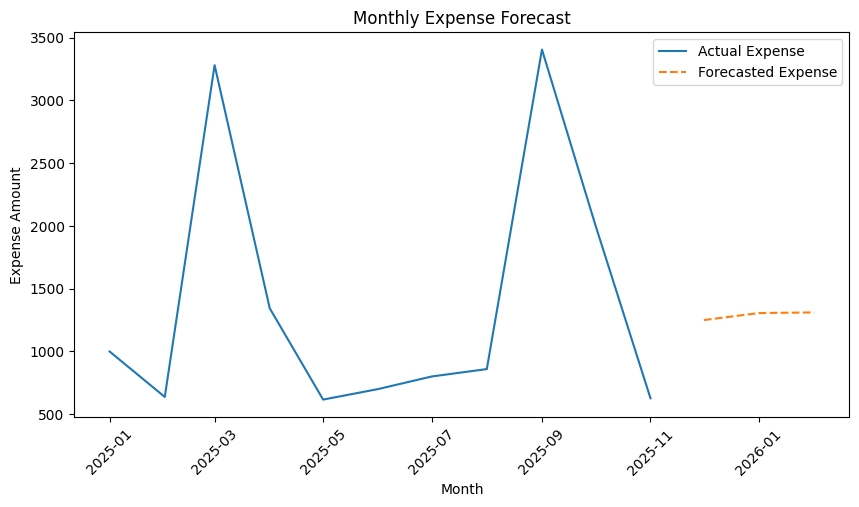

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(monthly_expense.index, monthly_expense.values, label="Actual Expense")
plt.plot(forecast.index, forecast.values, label="Forecasted Expense", linestyle="--")
plt.title("Monthly Expense Forecast")
plt.xlabel("Month")
plt.ylabel("Expense Amount")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [24]:
df.to_csv(r"C:\Users\user\OneDrive\Documents\finance_ai\data\Finance_Final.csv", index=False)


# Save Your ML Model

In [25]:
import pickle
import os

os.makedirs("../model", exist_ok=True)

with open("../model/classifier.pkl", "wb") as f:
    pickle.dump(model, f)

with open("../model/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("Correct model saved!")


Correct model saved!


In [22]:
import pickle

with open(r"C:\Users\user\OneDrive\Documents\finance_ai\model\classifier.pkl", 'wb') as f:
    pickle.dump(model, f)

with open(r"C:\Users\user\OneDrive\Documents\finance_ai\model\vectorizer.pkl", 'wb') as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!


Install Streamlit

In [23]:
pip install streamlit


   ---------------------------------------- 0.0/9.0 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.0 MB 4.8 MB/s eta 0:00:02
   -------- ------------------------------- 1.8/9.0 MB 5.6 MB/s eta 0:00:02
   --------------- ------------------------ 3.4/9.0 MB 5.8 MB/s eta 0:00:01
   ------------------- -------------------- 4.5/9.0 MB 5.7 MB/s eta 0:00:01
   -------------------------- ------------- 6.0/9.0 MB 6.1 MB/s eta 0:00:01
   --------------------------------- ------ 7.6/9.0 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 9.0/9.0 MB 6.4 MB/s  0:00:01
   ---------------------------------------- 0.0/795.4 kB ? eta -:--:--
   ---------------------------------------- 795.4/795.4 kB 5.7 MB/s  0:00:00
   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   ------ --------------------------------- 1.0/6.9 MB 7.1 MB/s eta 0:00:01
   ---------------- ----------------------- 2.9/6.9 MB 7.0 MB/s eta 0:00:01
   ------------------------ -----

In [1]:
import pickle
import os

os.makedirs("../model", exist_ok=True)

with open("../model/classifier.pkl", "wb") as f:
    pickle.dump(model, f)

with open("../model/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("Correct model saved!")


NameError: name 'model' is not defined